In [ ]:
# Create splits & upload processed data


In [1]:
REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

In [2]:
import boto3, os, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

session = boto3.session.Session(region_name=REGION)
s3 = session.client("s3")


In [3]:
import boto3, io
import pandas as pd

s3 = boto3.client("s3", region_name=REGION)
key = f"{PREFIX}/data/raw/creditcard.csv"

try:
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    df = pd.read_csv(io.BytesIO(obj["Body"].read()))
    display(df.head())
    print(f"Loaded from s3://{BUCKET}/{key}  |  rows={len(df)} cols={df.shape[1]}")
except s3.exceptions.NoSuchKey:
    raise FileNotFoundError(f"Could not find s3://{BUCKET}/{key}. Double-check BUCKET/PREFIX and that the file exists.")


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Loaded from s3://udacity-fraud-capstone/fraud/data/raw/creditcard.csv  |  rows=284807 cols=31


(284807, 31)
0 missing values total
Class
0    284315
1       492
Name: count, dtype: int64


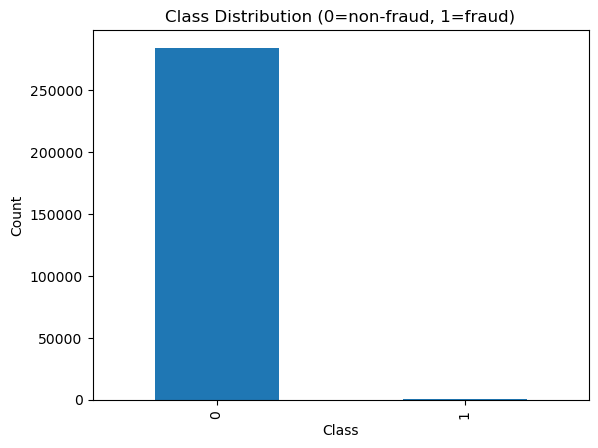

In [5]:
# Basic stats and class balance
print(df.shape)
print(df.isna().sum().sum(), "missing values total")
print(df['Class'].value_counts())
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution (0=non-fraud, 1=fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [6]:
# Scale Amount and Time, keep PCA features V1..V28 as-is
scaler = RobustScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time','Amount']])

X = df.drop(columns=['Class'])
y = df['Class']

Xtr, Xtmp, ytr, ytmp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
Xval, Xte,  yval, yte = train_test_split(Xtmp, ytmp, test_size=0.5, stratify=ytmp, random_state=42)

train = pd.concat([Xtr, ytr], axis=1)
val   = pd.concat([Xval, yval], axis=1)
test  = pd.concat([Xte, yte], axis=1)

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)


In [7]:
# Upload splits to S3
for name in ["train.csv","val.csv","test.csv"]:
    s3.upload_file(Filename=name, Bucket=BUCKET, Key=f"{PREFIX}/data/processed/{name}")
print("Uploaded splits to S3")


Uploaded splits to S3


In [8]:
#Verify
import boto3
s3 = boto3.client("s3", region_name="us-east-1")
resp = s3.list_objects_v2(Bucket="udacity-fraud-capstone", Prefix="fraud/data/processed/")
for o in resp.get("Contents", []):
    print(o["Key"], o["Size"])


fraud/data/processed/test.csv 15813861
fraud/data/processed/train.csv 126512455
fraud/data/processed/val.csv 15813858


In [9]:
import boto3, io, pandas as pd

REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

s3 = boto3.client("s3", region_name=REGION)

def read_csv_s3(key):
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj["Body"].read()))

def write_csv_s3(df, key):
    # No header, no index for XGBoost
    buf = io.BytesIO()
    df.to_csv(buf, index=False, header=False)
    buf.seek(0)
    s3.upload_fileobj(buf, BUCKET, key)

# 1) Load processed splits we created earlier
train = read_csv_s3(f"{PREFIX}/data/processed/train.csv")
val   = read_csv_s3(f"{PREFIX}/data/processed/val.csv")

# 2) Move 'Class' to FIRST column
def move_label_first(df, label="Class"):
    cols = [c for c in df.columns if c != label]
    return df[[label] + cols]

train_xgb = move_label_first(train)
val_xgb   = move_label_first(val)

# 3) Quick sanity checks
assert train_xgb.columns[0] == "Class" and val_xgb.columns[0] == "Class"
assert set(train_xgb["Class"].unique()) <= {0,1}, "Label must be 0/1"

# 4) Upload XGB-friendly versions (no header) to a new prefix
write_csv_s3(train_xgb, f"{PREFIX}/data/processed_xgb/train.csv")
write_csv_s3(val_xgb,   f"{PREFIX}/data/processed_xgb/val.csv")

print("Uploaded:")
print(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/train.csv")
print(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/val.csv")



Uploaded:
s3://udacity-fraud-capstone/fraud/data/processed_xgb/train.csv
s3://udacity-fraud-capstone/fraud/data/processed_xgb/val.csv


In [10]:
import boto3, io, pandas as pd, numpy as np

REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

s3 = boto3.client("s3", region_name=REGION)

def read_csv_s3(key):
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj["Body"].read()))

def write_csv_s3(df, key):
    buf = io.BytesIO()
    df.to_csv(buf, index=False, header=False)
    buf.seek(0)
    s3.upload_fileobj(buf, BUCKET, key)

train = read_csv_s3(f"{PREFIX}/data/processed/train.csv")
val   = read_csv_s3(f"{PREFIX}/data/processed/val.csv")

# keep numeric columns + Class
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
assert "Class" in num_cols, "Class column missing"
num_cols = [c for c in num_cols if c != "Class"]

def to_xgb(df):
    df = df[["Class"] + num_cols].copy()
    df["Class"] = df["Class"].astype("int32")
    feats = df.columns[1:]
    df[feats] = df[feats].astype("float32")
    df[feats] = df[feats].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df

train_xgb = to_xgb(train)
val_xgb   = to_xgb(val)

write_csv_s3(train_xgb, f"{PREFIX}/data/processed_xgb/train.csv")
write_csv_s3(val_xgb,   f"{PREFIX}/data/processed_xgb/val.csv")

print("Rewrote:")
print(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/train.csv")
print(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/val.csv")

# quick peek first 2 lines (should start with 0 or 1; no header)
for name in ["train","val"]:
    obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/{name}.csv")
    head = obj["Body"].read(200).decode("utf-8","ignore").splitlines()[:2]
    print(f"\n== {name}.csv head ==\n", head)


Rewrote:
s3://udacity-fraud-capstone/fraud/data/processed_xgb/train.csv
s3://udacity-fraud-capstone/fraud/data/processed_xgb/val.csv

== train.csv head ==
 ['0,0.90728277,1.9467467,-0.7525258,-1.3551295,-0.6616299,1.5028219,4.024933,-1.4796615,1.1398802,1.4068187,-0.15740292,-0.113729194,0.51027745,0.06125778,-0.06655514,1.3287019,0.3525139,-0.7656698,0.14']

== val.csv head ==
 ['0,-0.54464924,1.2459135,0.14967161,-0.45814517,0.10588639,0.59817284,0.20481576,0.23533736,0.036098562,-0.35988933,0.06568858,0.6546397,0.62801635,0.047495157,0.65725887,0.40839884,0.27706358,-0.64059']
